<a href="https://colab.research.google.com/github/shadab4150/Deep-Learning-Classifiers/blob/master/Tom_and_Jerry_emotion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as immg
import pandas as pd
import numpy as np
from fastai.vision import *
import seaborn as sns

In [2]:
!unzip '/content/96714c94-6-Dataset.zip'

Archive:  /content/96714c94-6-Dataset.zip
   creating: Dataset/
  inflating: Dataset/Test Tom and Jerry.mp4  
  inflating: Dataset/Test.csv        
  inflating: Dataset/Train Tom and jerry.mp4  
  inflating: Dataset/Train.csv       


In [40]:
videoFile = "/content/Dataset/Test Tom and Jerry.mp4"

cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=0
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename = '/content/test_tomjer/test' +  str(int(x)) + ".jpg";x+=1
        cv2.imwrite(filename, frame)

cap.release()
print ("Done!")

Done!


In [0]:
import shutil

In [10]:
shutil.make_archive('train_tom','zip','/content/train_tj/')

'/content/train_tom.zip'

In [81]:
shutil.make_archive('test_tomjer','zip','/content/test_tomjer/')

'/content/test_tomjer.zip'

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/test_tom.zip" "/content/drive/My Drive/Dataset/"
!cp "/content/train_tom.zip" "/content/drive/My Drive/Dataset/"

In [0]:
tr = pd.read_csv('/content/Dataset/Train.csv')
ts = pd.read_csv('/content/Dataset/Test.csv')

In [18]:
tr.head()

,Frame_ID,Emotion
0,frame0.jpg,happy
1,frame1.jpg,happy
2,frame2.jpg,surprised
3,frame3.jpg,surprised
4,frame4.jpg,angry


In [49]:
ts.tail()

,Frame_ID
181,test181.jpg
182,test182.jpg
183,test183.jpg
184,test184.jpg
185,test185.jpg


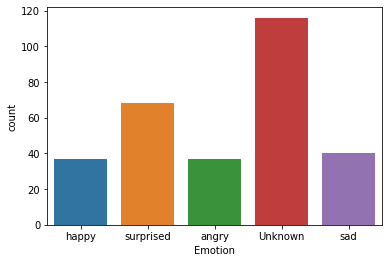

In [23]:
sns.countplot(tr.Emotion);

In [0]:
path = Path('/content/')

In [0]:
tfms = get_transforms(do_flip=True,max_lighting=0.2)

In [0]:
test = ImageList.from_df(ts,path,folder='test_tomjer',cols='Frame_ID')

In [0]:
data = (ImageList.from_df(tr, path, folder='train_tj',cols='Frame_ID')
                .split_by_rand_pct(0.1,seed=23)
                .label_from_df(cols='Emotion')
                .transform(tfms,size=256)
                .add_test(test)
                .databunch(bs=128).normalize(imagenet_stats))


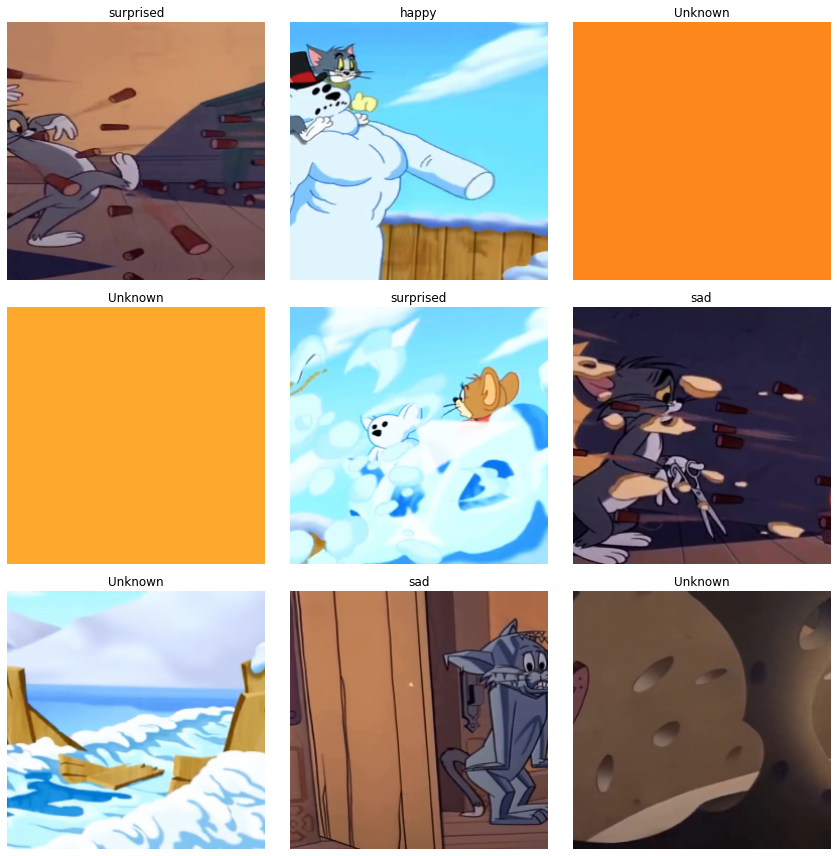

In [43]:
data.show_batch(rows=3)

In [45]:
data.classes, len(data.train_ds),len(data.valid_ds),len(data.test_ds)

(['Unknown', 'angry', 'happy', 'sad', 'surprised'], 269, 29, 186)

In [0]:
fb = FBeta()
fb.average = 'weighted'

In [0]:
learn = cnn_learner(data, models.resnet18 , metrics=[fb,accuracy])

In [54]:
import gc
gc.collect()

366

In [55]:
learn.fit_one_cycle(8, slice(1e-2))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,2.434168,6.062278,0.105172,0.172414,00:15
1,2.105160,12.459131,0.238029,0.275862,00:14
2,1.764009,8.258582,0.302974,0.344828,00:14
3,1.518020,5.305308,0.384856,0.413793,00:14
4,1.308769,3.572170,0.549120,0.551724,00:14
5,1.218806,2.811910,0.617839,0.620690,00:14
6,1.113815,2.401299,0.653607,0.655172,00:14
7,1.040402,2.169446,0.723712,0.724138,00:14


In [0]:
learn.save('tom1');
learn.load('tom1');

In [84]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-5,1e-2/5))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.572918,1.952466,0.761434,0.758621,00:16
1,0.522307,1.667847,0.829065,0.827586,00:14
2,0.476613,1.583851,0.829065,0.827586,00:14
3,0.437444,1.578707,0.795040,0.793103,00:14
4,0.428583,1.544888,0.795040,0.793103,00:15


In [86]:
learn.fit_one_cycle(3,slice(1e-4,1e-3/5))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.187174,1.571536,0.727386,0.724138,00:14
1,0.199493,1.497090,0.790968,0.793103,00:14


In [0]:
learn.save('tom2')

In [91]:
gc.collect()

6340

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


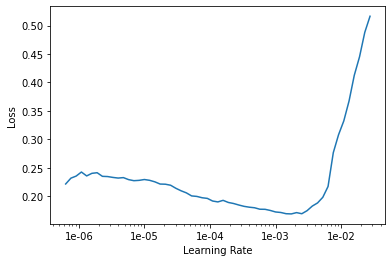

In [90]:
learn.lr_find()
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(4,max_lr = slice(1e-4,1e-3) )

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.175910,1.386259,0.861757,0.862069,00:14
1,0.196635,1.214129,0.861757,0.862069,00:15
2,0.204089,1.117616,0.861757,0.862069,00:15
3,0.188788,1.099365,0.861757,0.862069,00:15


In [0]:
learn.save('tom86');

In [0]:
learn.load('tom86');

In [97]:
interp = ClassificationInterpretation.from_learner(learn)

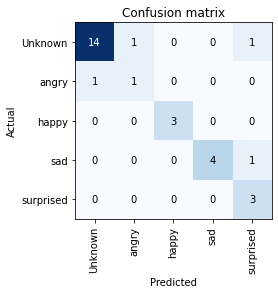

In [99]:
interp.plot_confusion_matrix()

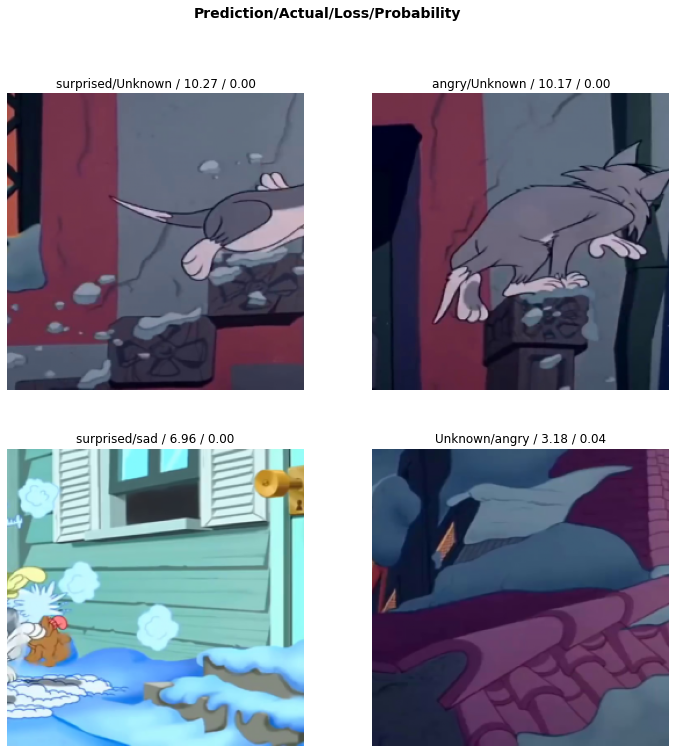

In [100]:
interp.plot_top_losses(k=4)

In [63]:
preds = learn.get_preds(DatasetType.Test)

In [0]:
from tqdm import tqdm

In [0]:
files=ts.Frame_ID.values

In [93]:
result = []
for i in tqdm(range(186)):
  k = '/content/test_tomjer/'+str(files[i])
  img = open_image(k)
  re = str(learn.predict(img)[0])
  result.append(re)
ts['Emotion'] = result
ts.to_csv('submitTom2.csv',index=False)

100%|██████████| 186/186 [00:10<00:00, 16.85it/s]


In [76]:
ts.head()

,Frame_ID,Emotion
0,test0.jpg,surprised
1,test1.jpg,angry
2,test2.jpg,Unknown
3,test3.jpg,Unknown
4,test4.jpg,surprised


In [77]:
ts.isna().sum()

Frame_ID    0
Emotion     0
dtype: int64